<a href="https://colab.research.google.com/github/rahul-velamala/unet_segmentation/blob/main/Copy_of_notebook1024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  rahulvelamala


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset


100%|██████████| 3.79G/3.79G [00:46<00:00, 88.1MB/s]


In [ ]:
import os
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
import shutil
%matplotlib inline

2024-06-27 17:34:27.126851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 17:34:27.126950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 17:34:27.240245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!pip install patchify
from patchify import patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


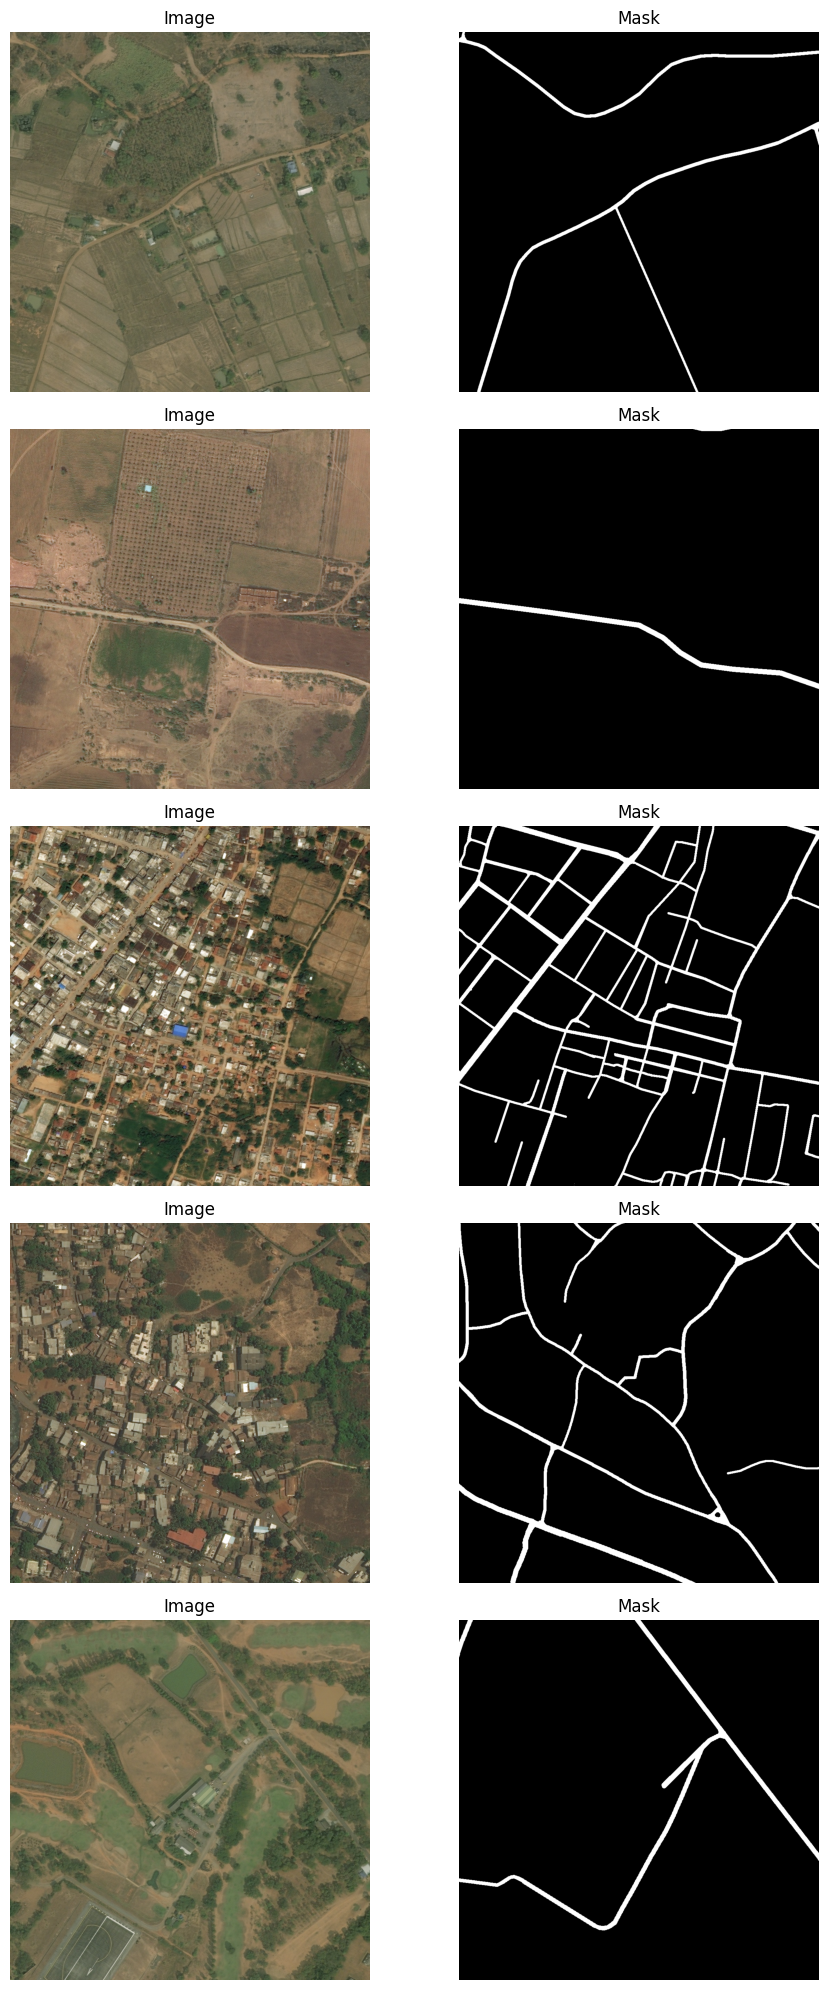

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness


def sort_by_name(arr, split_at):
    return sorted([f for f in arr if f.split(split_at)[0].isdigit()], key=lambda x: int(x.split(split_at)[0]))

def load_data(dir_path):
    directory = os.listdir(dir_path)
    images = []
    masks = []

    for filename in directory:
        if filename.split('.')[1] == 'jpg':
            images.append(filename)
        elif filename.split('.')[1] == 'png':
            masks.append(filename)

    sorted_images = sort_by_name(images, '_')
    sorted_masks = sort_by_name(masks, '_')

    return np.array(sorted_images), np.array(sorted_masks)

def preprocess_data(root_path, sorted_images, sorted_masks, input_size, augmented=False):
    images = []
    masks = []
    for img_file, mask_file in zip(sorted_images, sorted_masks):
        img = load_img(os.path.join(root_path, img_file), target_size=input_size, color_mode='rgb')
        mask = load_img(os.path.join(root_path, mask_file), target_size=input_size, color_mode='grayscale')

        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        mask_array = img_to_array(mask, dtype=np.bool_)

        # Append images and masks to the lists
        images.append(img_array)
        masks.append(mask_array)

        if augmented:
            images.append(flip_left_right(img_array))
            masks.append(flip_left_right(mask_array))

            images.append(flip_up_down(img_array))
            masks.append(flip_up_down(mask_array))


    images = np.array(images)
    masks = np.array(masks)

    return images, masks

def display_data(dir_path, image_paths, mask_paths):
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):

        image = plt.imread(os.path.join(dir_path, image_path))
        mask = plt.imread(os.path.join(dir_path, mask_path))


        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')


    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')


    plt.show()
    return


dir_path = '/kaggle/working/deepglobe-road-extraction-dataset/train'
image_filenames, mask_filenames = load_data(dir_path)

# Display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout

def unet(input_size=(1024, 1024, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:

INPUT_SIZE = (1024, 1024)
INPUT_SHAPE = (1024, 1024,3)

In [ ]:

input_size =  (1024, 1024)
total_images = len(image_filenames)
half_images = 500


half_image_filenames = image_filenames[:half_images]
half_mask_filenames = mask_filenames[:half_images]

print(f"Total images: {total_images}")
print(f"Using {half_images} images for preprocessing")

images, masks = preprocess_data(dir_path, half_image_filenames, half_mask_filenames, input_size)
print(f"Preprocessed images shape: {images.shape}")
print(f"Preprocessed masks shape: {masks.shape}")

Total images: 6226
Using 500 images for preprocessing
Preprocessed images shape: (500, 1024, 1024, 3)
Preprocessed masks shape: (500, 1024, 1024, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# split the training data into training and testing sets
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)


print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Validation masks shape: {val_masks.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Train images shape: (320, 1024, 1024, 3)
Validation images shape: (100, 1024, 1024, 3)
Train masks shape: (320, 1024, 1024, 1)
Validation masks shape: (100, 1024, 1024, 1)
Test images shape: (80, 1024, 1024, 3)
Test masks shape: (80, 1024, 1024, 1)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/models/save_best.keras', verbose=1, save_best_only=True)

In [ ]:
model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1024,      │      1,792 │ input_layer[0][0] │
│                     │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024,      │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1024,      │     36,928 │ batch_normalizat… │
│                     │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024,      │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 512, 512,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 512, 512,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │  1,180,160 │ max_pooling2d_2[

 Total params: 31,402,497 (119.79 MB)

 Trainable params: 31,390,721 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import datetime


mixed_precision.set_global_policy('mixed_float16')


def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * (p * r) / (p + r + K.epsilon())
    return f1

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint = ModelCheckpoint('model_best.keras', monitor='val_loss', save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


initial_learning_rate = 1e-4
model.compile(optimizer=AdamW(learning_rate=initial_learning_rate),
              loss=jacard_coef_loss,
              metrics=[precision, recall, f1_score, iou])


batch_size = 1

with tf.device("/GPU:0"):
    history = model.fit(train_images, train_masks,
                        batch_size=batch_size,
                        epochs=20,
                        validation_data=(val_images, val_masks),
                        callbacks=[tensorboard_callback, checkpoint, reduce_lr, early_stopping])


Epoch 1/20


2024-06-27 17:36:26.457044: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[1,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1536,128,128]{3,2,1,0}, f32[512,1536,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-27 17:36:26.464472: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.007558641s
Trying algorithm eng13{} for conv (f32[1,512,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1536,128,128]{3,2,1,0}, f32[512,1536,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking 

320/320 ━━━━━━━━━━━━━━━━━━━━ 587s 1s/step - f1_score: 0.1711 - iou: 0.0925 - loss: -0.0925 - precision: 0.1073 - recall: 0.7239 - val_f1_score: 0.0024 - val_iou: 0.0031 - val_loss: -0.0032 - val_precision: 0.0078 - val_recall: 0.0014 - learning_rate: 1.0000e-04
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - f1_score: 0.3185 - iou: 0.1834 - loss: -0.1834 - precision: 0.2389 - recall: 0.7452 - val_f1_score: 0.3647 - val_iou: 0.2327 - val_loss: -0.2328 - val_precision: 0.2695 - val_recall: 0.7427 - learning_rate: 1.0000e-04
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - f1_score: 0.4162 - iou: 0.2496 - loss: -0.2497 - precision: 0.3413 - recall: 0.7562 - val_f1_score: 0.3986 - val_iou: 0.2649 - val_loss: -0.2649 - val_precision: 0.3526 - val_recall: 0.6285 - learning_rate: 1.0000e-04
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - f1_score: 0.4916 - iou: 0.3175 - loss: -0.3176 - precision: 0.4345 - recall: 0.7415 - val_f1_score: 0.3677 - val_iou: 0.2376 - val_loss: 

In [ ]:
model.save('/kaggle/working/models/roads_extraction.h5')

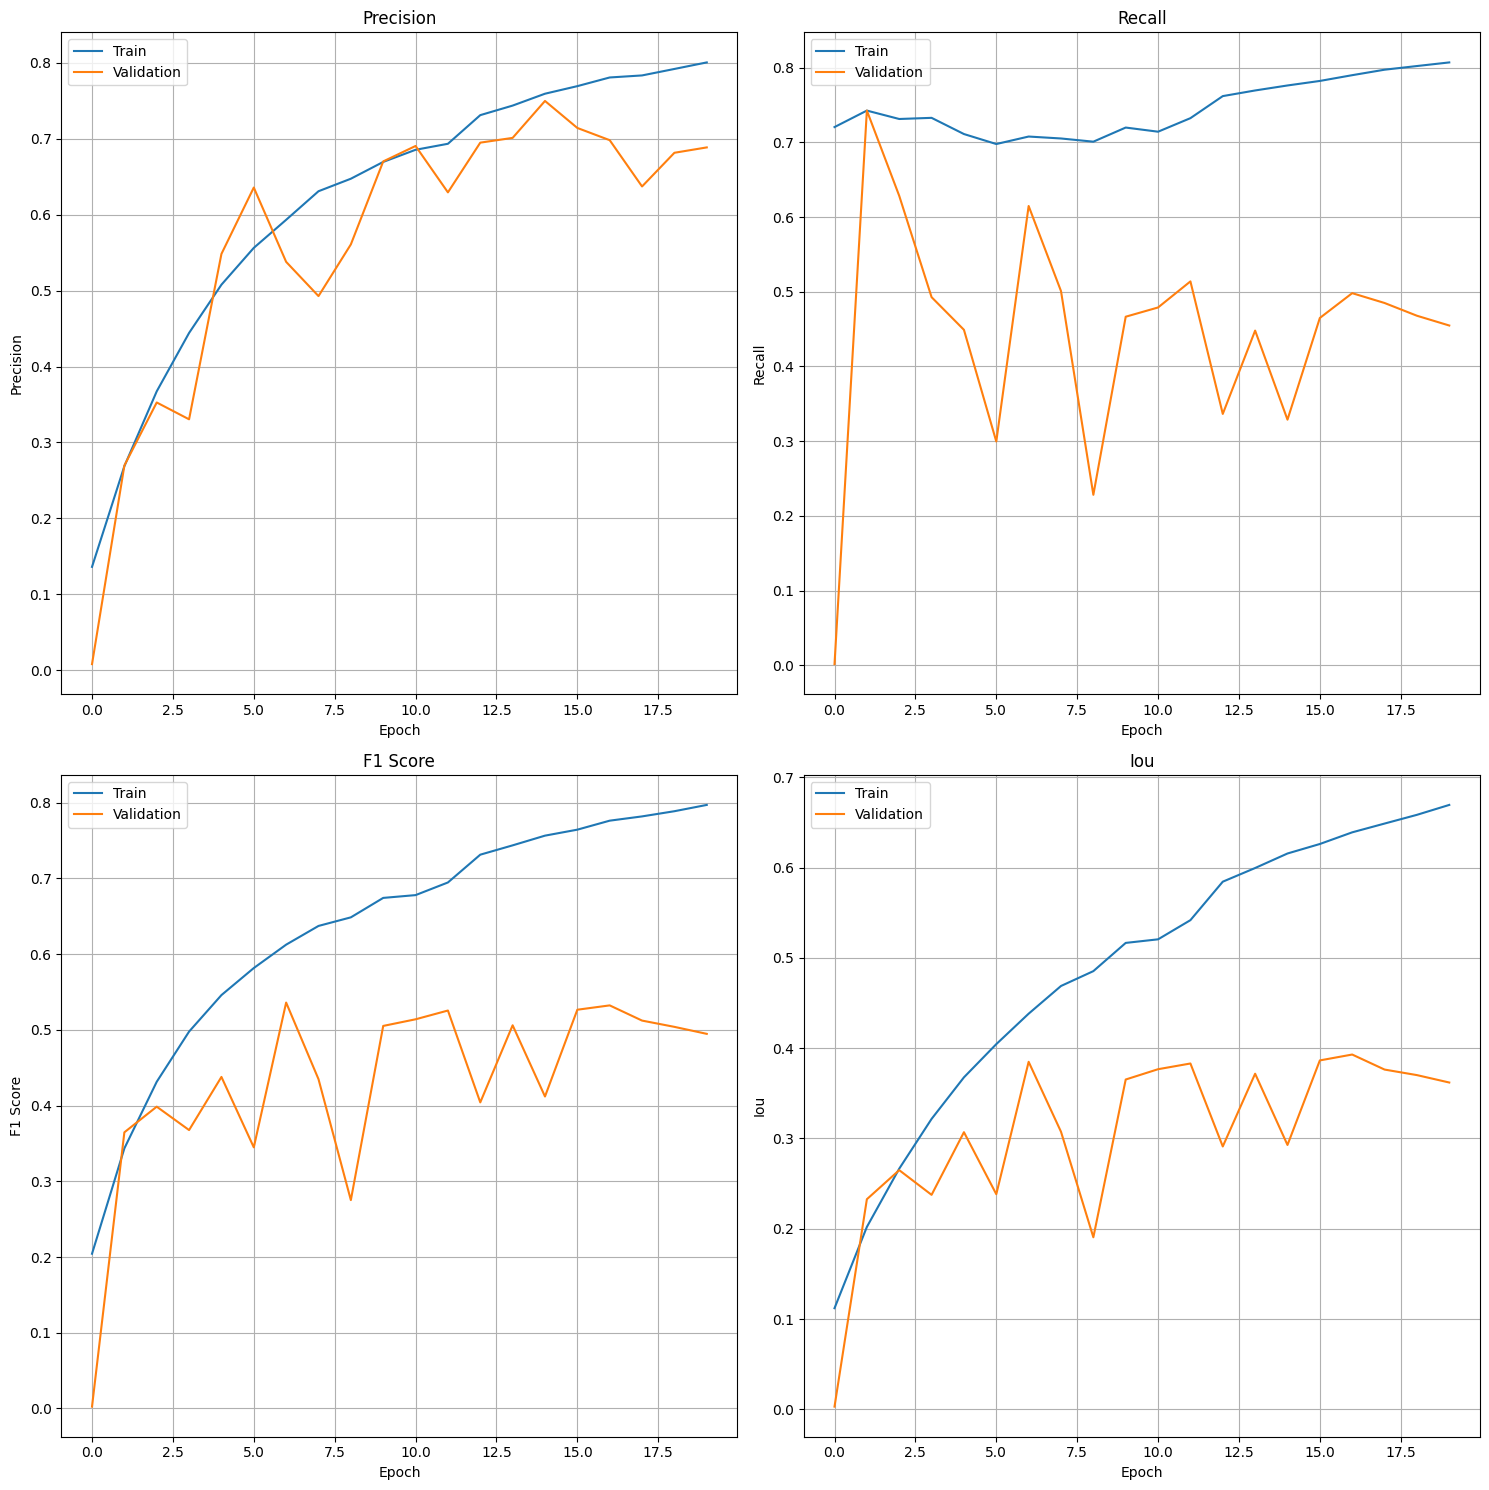

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['precision', 'recall', 'f1_score', 'iou']
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        ax.plot(history.history[metric], label='Train')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_metrics(history)